In [ ]:
!pip install --upgrade tensorflow_datasets

     |████████████████████████████████| 3.6MB 2.5MB/s 
  Found existing installation: tensorflow-datasets 2.1.0
    Uninstalling tensorflow-datasets-2.1.0:
      Successfully uninstalled tensorflow-datasets-2.1.0


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

print(tf.__version__)

2.3.0


# Dataset

In [ ]:
ds, ds_info = tfds.load('cats_vs_dogs', split='train[:80%]', with_info=True)
ds_test, ds_test_info = tfds.load('cats_vs_dogs', split='train[-20%:]', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteOU7NBX/cats_vs_dogs-train.tfrecord


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


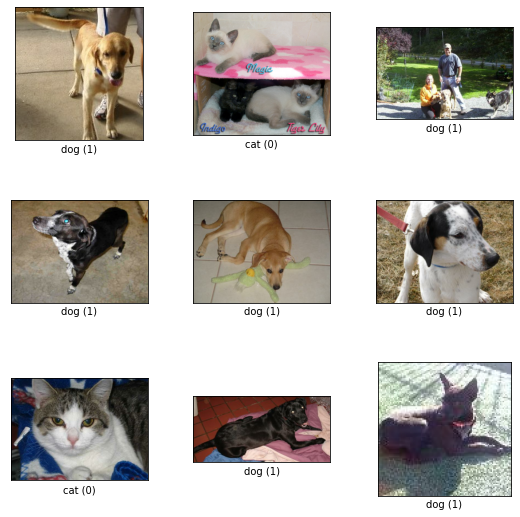

In [ ]:
test_examples = tfds.show_examples(ds_test, ds_test_info)

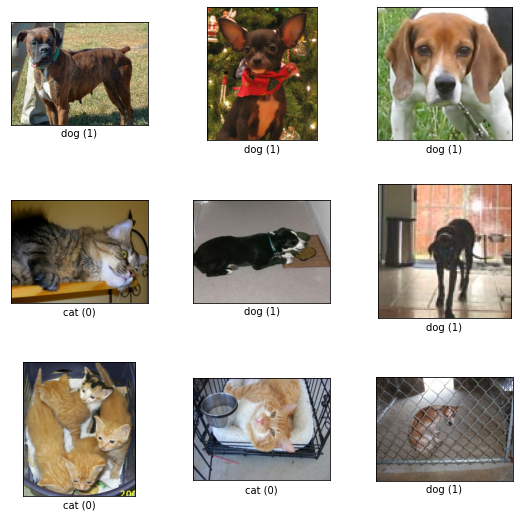

In [ ]:
train_exampels = tfds.show_examples(ds, ds_info)

# Pretrained Mobile Net

In [ ]:
import urllib.request
import json

def build_model():
  mobilenet = keras.applications.MobileNet(input_shape=(224, 224, 3))
  inputs = mobilenet.input
  conv_preds = mobilenet.get_layer('conv_preds')
  outputs = conv_preds.output

  return keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model = build_model()
model.output

17227776/17225924 [==============================] - 0s 0us/step


<tf.Tensor 'conv_preds/BiasAdd:0' shape=(None, 1, 1, 1000) dtype=float32>

# KNN Classifier

In [ ]:
# @title </> Functions for testing prediction
import random
def plot_predictions(images, classes, confidences, split=5, figsize=(11,6)):
  img_splits = np.array_split(images, split)
  cls_splits = np.array_split(classes, split)
  conf_splits = np.array_split(confidences, split)
  num_examples = len(conf_splits[0])

  f, axs = plt.subplots(len(img_splits), num_examples, figsize=figsize)

  for i, (img_split, cls_split, conf_split) in enumerate(zip(img_splits, cls_splits, conf_splits)):
    for j, (img, cls, conf) in enumerate(zip(img_split, cls_split, conf_split)):
      ax = axs[i, j]
      ax.imshow(img)
      ax.set_title(f'{cls} ({conf*100}%)')

  plt.tight_layout()

def take_only(ds, label='dogs', num_examples=15, shuffle=True):
  def _filter(x, lb=label):
    l = x['label']
    return tf.equal(l, lb)
  
  if (shuffle):
    ds = ds.shuffle(32)

  return ds.filter(_filter).take(num_examples)


def take_equally(ds, num_examples=15, shuffle=True):
  dogs = take_only(ds, 1, num_examples, shuffle)
  cats = take_only(ds, 0, num_examples, shuffle)

  return cats, dogs

def predict_equally(model, knn, ds, num_examples=10, shuffle=True, plot=False):
  cats, dogs = take_equally(ds, num_examples, shuffle)
  batch = cats.concatenate(dogs)

  return _predict(model, knn, batch, num_examples, plot)


def predict_randomly(model, knn, ds, num_examples=10, plot=False):
  skip = random.randint(1, len(ds))
  ds = ds.skip(skip).take(num_examples)

  return _predict(model, knn, ds, num_examples, plot)

def _predict(model, knn, ds, num_examples=10, plot=False):
  images = []
  classes = []
  confidences = []

  for input in ds:
    image = input['image']
    image = tf.reshape(resize_image(image), (1, 224, 224, 3))
    label = input['label']
    example = model.predict(tf.convert_to_tensor(image))
    _, top_label, prob = knn.predict_class(example, 5)
    
    images.append(input['image'])
    classes.append(top_label)
    confidences.append(prob[top_label])

  if plot:
    plot_predictions(images, classes, confidences)

  return images, classes, confidences

def test(model, knn, test_ds):
  accuracy = 0
  count = 1
  for input in test_ds.take(-1):
    image = input['image']
    image = tf.reshape(resize_image(image), (1, 224, 224, 3))
    label = input['label']

    example = model.predict(tf.convert_to_tensor(image))
    _, top_label, prob = knn.predict_class(example, 5)
    
    if top_label.decode('utf-8') == true_labels[label.numpy()]:
      accuracy += 1

    print(f'\rCurrent accuracy: {100*accuracy/count:2f}%', end='')
    count += 1

  return 100 * accuracy / count


In [ ]:
def concat_with_nulls(a, b):
  if a is None and b is None:
    return None
  
  if a is None:
    return tf.identity(b)
  elif b is None:
    return tf.identity(a)

  return tf.concat([a, b], axis=0, name='concat_with_nulls')

def resize_image(image):
  return tf.cast(tf.image.resize(image, (224,224), method='nearest'), dtype=tf.float32)

def top_k(similarities, k):
  if similarities.ndim != 1:
    similarities = tf.reshape(similarities, -1)

  sorted_indices = tf.argsort(similarities, direction='DESCENDING', stable=True)[:k]
  sorted_similarities = tf.gather(similarities, sorted_indices)

  return {'values': sorted_similarities, 'indices': sorted_indices}
  

In [ ]:
from collections import defaultdict

class KNNClassifier:
  def __init__(self):
    self.logits = None
    self.X = None
    self.y = None
    self.class_example_count = defaultdict(int)
    self.example_shape = None
    self.label_to_class_id = {}
    self.next_class_id = 0

  def add_example(self, example, label):
    if not self.example_shape:
      self.example_shape = example.shape

    if self.example_shape != example.shape:
      raise ValueError(f'Example shape provided {example.shape} does not match \
                        previously provided example shape {self.example_shape}')
      
    self.clear_logits()

    if (label.numpy() not in self.label_to_class_id):
      self.label_to_class_id[label.numpy()] = self.next_class_id
      self.next_class_id += 1
    
    normalized_example = self._normalize_vector(tf.reshape(example, -1))
    example_size = len(normalized_example)
    x = tf.reshape(normalized_example, (1, example_size))
    y = tf.expand_dims(label, -1)
    
    if self.X is None:
      self.X = x
      self.y = y
    else:
      self.X = tf.concat([self.X, x], axis=0)
      self.y = tf.concat([self.y, y], axis=0)

    # Increase example counter.
    self.class_example_count[label.numpy()] += 1

  def _compute_similarities(self, example):
    normalized_example = self._normalize_vector(tf.reshape(example, -1))
    example_size = len(normalized_example)

    if self.logits is None:
      new_sim_scores = None

      for idx, label in enumerate(self.y):
        new_sim_scores = concat_with_nulls(new_sim_scores, self.X[idx])
      
      self.logits = new_sim_scores
    
    if self.logits is None:
      print('Can not predict without providing training examples.')
      return None
    
    num_examples = self._get_num_examples()
    # Compute the dot product similarity between the input and all examples in the dataset.
    similarities = tf.matmul(
        tf.reshape(tf.expand_dims(self.logits, -1), (num_examples, example_size)),
        tf.reshape(normalized_example, (example_size, 1)))

    return tf.reshape(similarities, -1)

  def predict_class(self, input, k=3):
    if k < 1:
      raise ValueError('Plesae provide a positive integer k value to predict_class.')
    
    if not self._get_num_examples():
      raise ValueError('You have not added any examples to the KNN Classifier. Please add examples before calling predict_class.')
    
    similarities = tf.cast(self._compute_similarities(input), dtype=tf.float32)
    # If not enough number of examples, use k equals to the number of examples.
    k_val = min(k, self._get_num_examples())
    top_k_values, top_k_indices = top_k(similarities, k_val).values()
    
    return self._calculate_top_class(top_k_indices, k_val)

  def _calculate_top_class(self, top_k_indices, k_val):
    top_label = None
    confidences = {}
    labels, _ = tf.unique(self.y)
    labels = labels.numpy()

    class_offsets = {}
    offset = 0
    for label in labels:
      offset += self.class_example_count[label]
      class_offsets[label] = offset

    votes_per_class = defaultdict(int)
    for index in top_k_indices:
      for label in labels:
        if index < class_offsets[label]:
          votes_per_class[label] += 1
          break

    # # Hard voting.
    # top_k_class = tf.gather(self.y, top_k_indices).numpy()
    # votes_per_class = defaultdict(int)
    # for label in top_k_class:
    #   votes_per_class[label] += 1
    
    top_confidence = 0
    for label in labels:
      probability = votes_per_class[label] / k_val
      if probability > top_confidence:
        top_confidence = probability
        top_label = label
      confidences[label] = probability

    return self.label_to_class_id[top_label], top_label, confidences

  def clear_logits(self):
    self.logits = None

  def _get_num_examples(self):
    return len(self.X)

  def _normalize_vector(self, vec):
    """Returns a unit vector of a given vector by dividing the vector by its norm."""
    return tf.truediv(vec, tf.norm(vec))

In [ ]:
true_labels = ['cat', 'dog']

In [ ]:
cats, dogs = take_equally(ds, shuffle=False)
batch = cats.concatenate(dogs)

images = []
labels = []
for example in batch:
  image = tf.image.resize(example['image'], (224,224), method='nearest')
  label = example['label']
  images.append(image)
  labels.append(tf.convert_to_tensor(true_labels[label.numpy()]))

preds = model.predict(tf.convert_to_tensor(images))
knn = KNNClassifier()

for (pred, label) in zip(preds, labels):
  knn.add_example(pred, label)

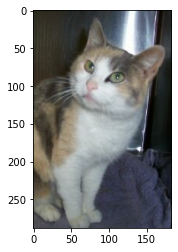

In [ ]:
exam = None
for e in ds.skip(100).take(1):
  exam = e['image']
  plt.imshow(e['image'])

In [ ]:
exam = tf.reshape(resize_image(exam), (1, 224, 224, 3))
example = model.predict(tf.convert_to_tensor(exam))

_, top_label, prob = knn.predict_class(example, 5)
# _, top_label1, prob1 = knn1.predict_class(example, 5)

top_label, prob

(b'cat', {b'cat': 0.6, b'dog': 0.4})

Try the classifier on 12 images (6 dogs, 6 cats)

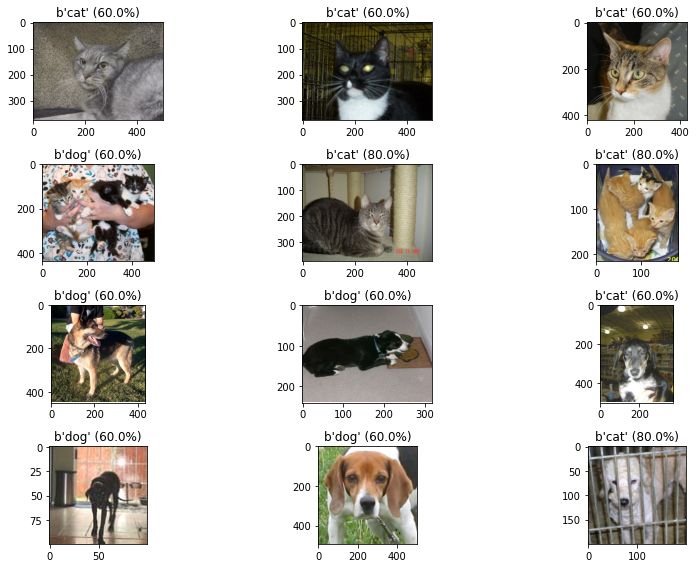

In [ ]:
a,b,c = predict_equally(model, knn, ds, num_examples=6)
plot_predictions(a,b,c, split=4, figsize=(12,8))